In [1]:
!pip install segmentation_models_pytorch warmup_scheduler albumentations -q


In [1]:
import os
import sys
import random
from glob import glob
import warnings

import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2

sys.path.append('/kaggle/working/notebook/experiment/2d')
from script.helper import *
from script.dataset import *
from script.metrics import *
from script.trainer import *
from script.model import *
from script.loss import *
from script.scheduler import *


## config

In [2]:
class ExtractLayers(A.ImageOnlyTransform):
    def __init__(self, in_channels, out_channels, is_train=True, always_apply=False, p=1):
        super(ExtractLayers, self).__init__(always_apply, p)
        self.is_train = is_train
        self.in_channels = in_channels
        self.out_channels = out_channels

    def apply(self, img, **params):
        if self.is_train:
            start = random.randint(0, self.in_channels-self.out_channels)
            end = start+self.out_channels
            img = img[:, :, start:end]
        else:
            img = img[:, :, 4:4+self.out_channels]
        return img


In [3]:
class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'
    comp_dir_path = '/kaggle/input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'

    dataset_path = "/kaggle/working/dataset_train/"
    train_dataset_path = "/kaggle/working/dataset_train/nonflatten/25-37/"
    dataset_range = train_dataset_path.split("/")[-2]
    
    exp_name = os.getcwd().split('/')[-1]

    # ============== model cfg =============
    model_name = 'UnetPlusPlus'
    backbone = 'se_resnext50_32x4d'
    in_chans = 6

    # ============== pred target =============
    target_size = 1

    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 16  # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'

    epochs = 20  # 15

    warmup_factor = 10
    lr = 1e-4 / warmup_factor
    loss="bce_loss"
    # ============== fold =============
    metric_direction = 'maximize'  # maximize, 'minimize'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== augmentation =============
    train_aug_list = [
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.ShiftScaleRotate(p=0.5),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(size * 0.3), max_height=int(size * 0.3),
                        mask_fill_value=0, p=0.5),
        ExtractLayers(13, 6, is_train=True),
        A.Normalize(
            mean=[0] * in_chans,
            std=[1] * in_chans,
            max_pixel_value=65535,
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        ExtractLayers(13, 6, is_train=False),
        A.Normalize(
            mean=[0] * in_chans,
            std=[1] * in_chans,
            max_pixel_value=65535,
        ),
        ToTensorV2(transpose_mask=True),
    ]


warnings.filterwarnings("ignore")
torch.backends.cudnn.benchmark = True  # type: ignore

set_seed(CFG.seed)
os.makedirs(f'./{CFG.exp_name}/', exist_ok=True)


## Dataset

In [4]:
def preprocess(image, fragment_i, split_i):
    # topography = cv2.imread(f"{CFG.dataset_path}/topography_{fragment_i}_{split_i}.png",-1)
    # topography = topography.astype("uint16")*1057
    # pad0 = (CFG.tile_size - topography.shape[0] % CFG.tile_size)
    # pad1 = (CFG.tile_size - topography.shape[1] % CFG.tile_size)
    # topography = np.pad(topography, [(0, pad0), (0, pad1)], constant_values=0)
    # topography = np.expand_dims(topography, axis=2)
    # image=np.concatenate([image,topography], axis=2)
    return image



len(train_images) = 14624
train_images[0].shape = (224, 224, 13)
train_labels[0].shape = (224, 224, 1)
train_masks[0].shape = (224, 224, 1)

len(valid_images) = 4161
valid_images[0].shape = (224, 224, 13)
valid_labels[0].shape = (224, 224, 1)



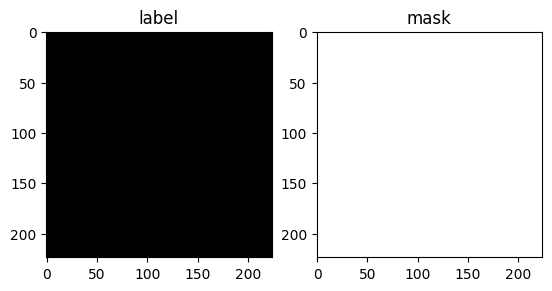

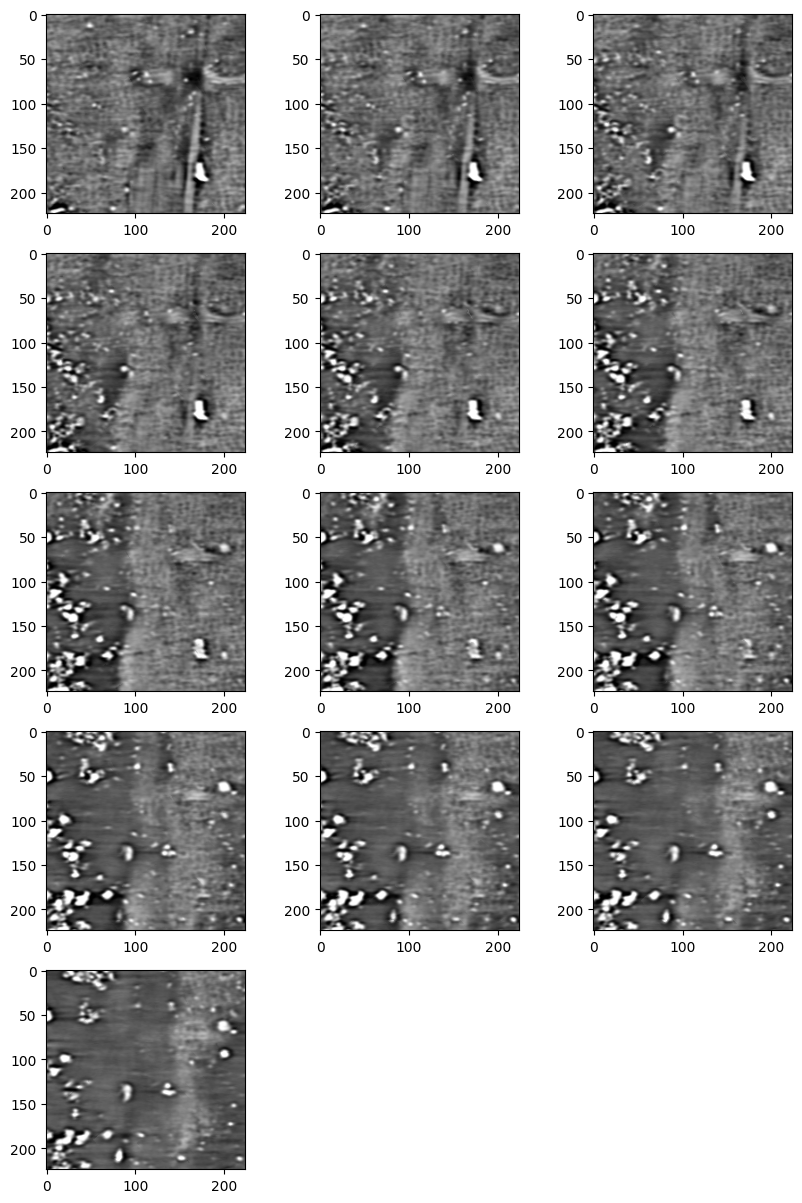

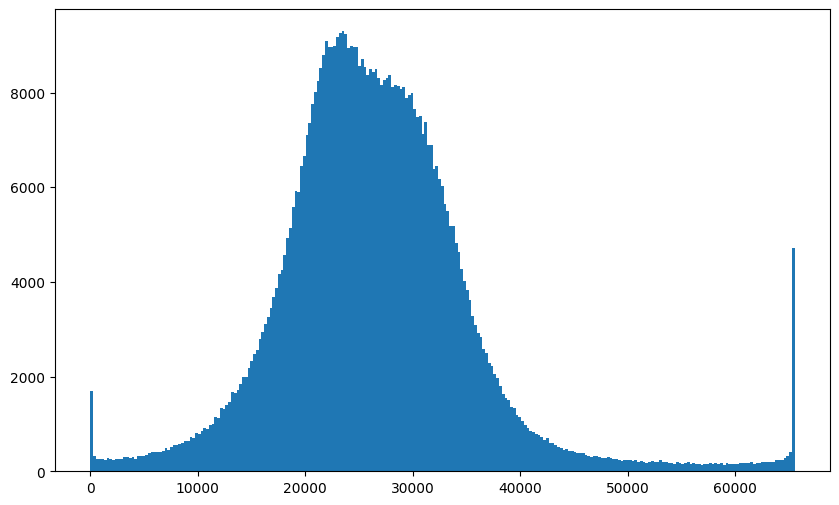

In [6]:
# confirmation

valid_fragment_i = 1
valid_split_i = 0

train_images, train_labels, train_masks, valid_images, valid_labels, valid_xyxys = get_train_valid_dataset(valid_fragment_i, valid_split_i, CFG, preprocess)

print(f"""
{len(train_images) = }
{train_images[0].shape = }
{train_labels[0].shape = }
{train_masks[0].shape = }

{len(valid_images) = }
{valid_images[0].shape = }
{valid_labels[0].shape = }
""")

id = random.randint(0, len(train_labels))
visualize_train_images(id, train_images, train_labels, train_masks)


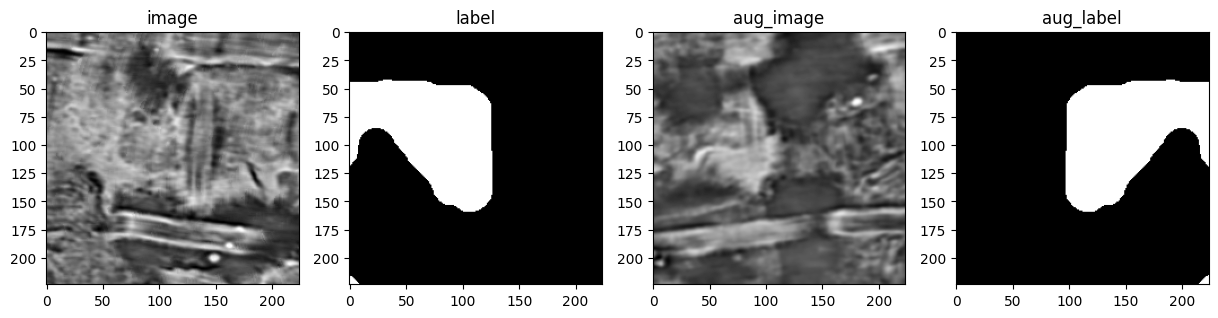

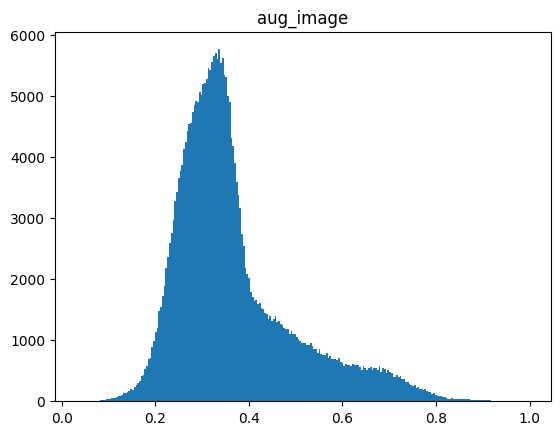

In [7]:
# confirmation
plot_dataset = CustomDataset(train_images, CFG, labels=train_labels)
visualize_dataset(plot_dataset, CFG)


## main

In [8]:
train_and_evaluate(preprocess, CFG)
!curl -X POST -H 'Authorization: Bearer '$LINE -F 'message=セルの実行が終わりました！' https://notify-api.line.me/api/notify

fold: 0
UnetPlusPlus


100%|██████████| 131/131 [00:13<00:00,  9.46it/s]


fbeta: 0.3571
Epoch 1 - avg_train_loss: 0.6337  avg_val_loss: 0.4553  avgScore: 0.3571  time: 158s
Epoch 1 - Save Best Loss: 0.4553  Best Score: 0.3571 Model



100%|██████████| 131/131 [00:13<00:00,  9.54it/s]


fbeta: 0.4442
Epoch 2 - avg_train_loss: 0.4251  avg_val_loss: 0.3927  avgScore: 0.4442  time: 156s
Epoch 2 - Save Best Loss: 0.3927  Best Score: 0.4442 Model



100%|██████████| 131/131 [00:13<00:00,  9.56it/s]


fbeta: 0.4451
Epoch 3 - avg_train_loss: 0.3192  avg_val_loss: 0.2786  avgScore: 0.4451  time: 155s
Epoch 3 - Save Best Loss: 0.2786  Best Score: 0.4451 Model



100%|██████████| 131/131 [00:13<00:00,  9.57it/s]


fbeta: 0.3169
Epoch 4 - avg_train_loss: 0.2507  avg_val_loss: 0.2767  avgScore: 0.3169  time: 156s



100%|██████████| 131/131 [00:13<00:00,  9.84it/s]


fbeta: 0.4954
Epoch 5 - avg_train_loss: 0.2332  avg_val_loss: 0.2311  avgScore: 0.4954  time: 154s
Epoch 5 - Save Best Loss: 0.2311  Best Score: 0.4954 Model



100%|██████████| 131/131 [00:13<00:00,  9.87it/s]


fbeta: 0.4840
Epoch 6 - avg_train_loss: 0.2238  avg_val_loss: 0.2399  avgScore: 0.4840  time: 153s



100%|██████████| 131/131 [00:13<00:00,  9.85it/s]


fbeta: 0.1876
Epoch 7 - avg_train_loss: 0.2161  avg_val_loss: 0.2722  avgScore: 0.1876  time: 152s



100%|██████████| 131/131 [00:13<00:00,  9.87it/s]


fbeta: 0.4789
Epoch 8 - avg_train_loss: 0.2070  avg_val_loss: 0.2473  avgScore: 0.4789  time: 152s



100%|██████████| 131/131 [00:13<00:00,  9.52it/s]


fbeta: 0.5518
Epoch 9 - avg_train_loss: 0.2014  avg_val_loss: 0.2403  avgScore: 0.5518  time: 154s
Epoch 9 - Save Best Loss: 0.2403  Best Score: 0.5518 Model



100%|██████████| 131/131 [00:13<00:00,  9.72it/s]


fbeta: 0.5152
Epoch 10 - avg_train_loss: 0.1931  avg_val_loss: 0.2359  avgScore: 0.5152  time: 153s



100%|██████████| 131/131 [00:13<00:00,  9.74it/s]


fbeta: 0.5245
Epoch 11 - avg_train_loss: 0.1871  avg_val_loss: 0.2340  avgScore: 0.5245  time: 153s



100%|██████████| 131/131 [00:13<00:00,  9.91it/s]


fbeta: 0.5387
Epoch 12 - avg_train_loss: 0.1793  avg_val_loss: 0.2377  avgScore: 0.5387  time: 153s



100%|██████████| 131/131 [00:13<00:00,  9.60it/s]


fbeta: 0.5200
Epoch 13 - avg_train_loss: 0.1714  avg_val_loss: 0.2510  avgScore: 0.5200  time: 154s



100%|██████████| 131/131 [00:13<00:00,  9.82it/s]


fbeta: 0.5424
Epoch 14 - avg_train_loss: 0.1648  avg_val_loss: 0.2447  avgScore: 0.5424  time: 152s



100%|██████████| 131/131 [00:13<00:00,  9.68it/s]


fbeta: 0.4859
Epoch 15 - avg_train_loss: 0.1588  avg_val_loss: 0.2536  avgScore: 0.4859  time: 154s



100%|██████████| 131/131 [00:13<00:00,  9.75it/s]


fbeta: 0.5198
Epoch 16 - avg_train_loss: 0.1521  avg_val_loss: 0.2571  avgScore: 0.5198  time: 153s



100%|██████████| 131/131 [00:13<00:00,  9.90it/s]


fbeta: 0.5513
Epoch 17 - avg_train_loss: 0.1464  avg_val_loss: 0.2432  avgScore: 0.5513  time: 153s



100%|██████████| 131/131 [00:13<00:00,  9.63it/s]


fbeta: 0.5483
Epoch 18 - avg_train_loss: 0.1416  avg_val_loss: 0.2654  avgScore: 0.5483  time: 154s



100%|██████████| 131/131 [00:13<00:00,  9.80it/s]


fbeta: 0.5411
Epoch 19 - avg_train_loss: 0.1382  avg_val_loss: 0.2622  avgScore: 0.5411  time: 153s



100%|██████████| 131/131 [00:13<00:00,  9.86it/s]


fbeta: 0.5250
Epoch 20 - avg_train_loss: 0.1364  avg_val_loss: 0.2665  avgScore: 0.5250  time: 154s

fold: 1
UnetPlusPlus


100%|██████████| 120/120 [00:12<00:00,  9.38it/s]


fbeta: 0.3535
Epoch 1 - avg_train_loss: 0.5174  avg_val_loss: 0.3028  avgScore: 0.3535  time: 160s
Epoch 1 - Save Best Loss: 0.3028  Best Score: 0.3535 Model



100%|██████████| 120/120 [00:12<00:00,  9.33it/s]


fbeta: 0.4302
Epoch 2 - avg_train_loss: 0.3578  avg_val_loss: 0.2339  avgScore: 0.4302  time: 158s
Epoch 2 - Save Best Loss: 0.2339  Best Score: 0.4302 Model



100%|██████████| 120/120 [00:12<00:00,  9.30it/s]


fbeta: 0.4336
Epoch 3 - avg_train_loss: 0.2842  avg_val_loss: 0.1522  avgScore: 0.4336  time: 158s
Epoch 3 - Save Best Loss: 0.1522  Best Score: 0.4336 Model



100%|██████████| 120/120 [00:12<00:00,  9.38it/s]


fbeta: 0.4827
Epoch 4 - avg_train_loss: 0.2542  avg_val_loss: 0.1404  avgScore: 0.4827  time: 157s
Epoch 4 - Save Best Loss: 0.1404  Best Score: 0.4827 Model



100%|██████████| 120/120 [00:12<00:00,  9.47it/s]


fbeta: 0.5807
Epoch 5 - avg_train_loss: 0.2445  avg_val_loss: 0.1312  avgScore: 0.5807  time: 157s
Epoch 5 - Save Best Loss: 0.1312  Best Score: 0.5807 Model



100%|██████████| 120/120 [00:12<00:00,  9.48it/s]


fbeta: 0.4861
Epoch 6 - avg_train_loss: 0.2347  avg_val_loss: 0.1350  avgScore: 0.4861  time: 156s



100%|██████████| 120/120 [00:12<00:00,  9.44it/s]


fbeta: 0.5421
Epoch 7 - avg_train_loss: 0.2285  avg_val_loss: 0.1348  avgScore: 0.5421  time: 157s



100%|██████████| 120/120 [00:12<00:00,  9.40it/s]


fbeta: 0.5477
Epoch 8 - avg_train_loss: 0.2194  avg_val_loss: 0.1356  avgScore: 0.5477  time: 156s



100%|██████████| 120/120 [00:12<00:00,  9.37it/s]


fbeta: 0.5149
Epoch 9 - avg_train_loss: 0.2147  avg_val_loss: 0.1387  avgScore: 0.5149  time: 157s



100%|██████████| 120/120 [00:12<00:00,  9.40it/s]


fbeta: 0.4981
Epoch 10 - avg_train_loss: 0.2075  avg_val_loss: 0.1584  avgScore: 0.4981  time: 157s



100%|██████████| 120/120 [00:12<00:00,  9.42it/s]


fbeta: 0.5935
Epoch 11 - avg_train_loss: 0.2001  avg_val_loss: 0.1381  avgScore: 0.5935  time: 157s
Epoch 11 - Save Best Loss: 0.1381  Best Score: 0.5935 Model



100%|██████████| 120/120 [00:12<00:00,  9.39it/s]


fbeta: 0.5818
Epoch 12 - avg_train_loss: 0.1943  avg_val_loss: 0.1343  avgScore: 0.5818  time: 157s



100%|██████████| 120/120 [00:12<00:00,  9.29it/s]


fbeta: 0.5571
Epoch 13 - avg_train_loss: 0.1860  avg_val_loss: 0.1396  avgScore: 0.5571  time: 157s



100%|██████████| 120/120 [00:12<00:00,  9.35it/s]


fbeta: 0.5644
Epoch 14 - avg_train_loss: 0.1820  avg_val_loss: 0.1400  avgScore: 0.5644  time: 159s



100%|██████████| 120/120 [00:12<00:00,  9.36it/s]


fbeta: 0.5829
Epoch 15 - avg_train_loss: 0.1736  avg_val_loss: 0.1415  avgScore: 0.5829  time: 158s



100%|██████████| 120/120 [00:12<00:00,  9.37it/s]


fbeta: 0.5711
Epoch 16 - avg_train_loss: 0.1673  avg_val_loss: 0.1468  avgScore: 0.5711  time: 159s



100%|██████████| 120/120 [00:12<00:00,  9.54it/s]


fbeta: 0.5962
Epoch 17 - avg_train_loss: 0.1637  avg_val_loss: 0.1438  avgScore: 0.5962  time: 157s
Epoch 17 - Save Best Loss: 0.1438  Best Score: 0.5962 Model



100%|██████████| 120/120 [00:12<00:00,  9.60it/s]


fbeta: 0.6039
Epoch 18 - avg_train_loss: 0.1578  avg_val_loss: 0.1456  avgScore: 0.6039  time: 156s
Epoch 18 - Save Best Loss: 0.1456  Best Score: 0.6039 Model



100%|██████████| 120/120 [00:12<00:00,  9.58it/s]


fbeta: 0.5883
Epoch 19 - avg_train_loss: 0.1538  avg_val_loss: 0.1550  avgScore: 0.5883  time: 155s



100%|██████████| 120/120 [00:12<00:00,  9.63it/s]


fbeta: 0.5933
Epoch 20 - avg_train_loss: 0.1524  avg_val_loss: 0.1535  avgScore: 0.5933  time: 155s

fold: 2
UnetPlusPlus


100%|██████████| 120/120 [00:12<00:00,  9.53it/s]


fbeta: 0.3603
Epoch 1 - avg_train_loss: 0.5803  avg_val_loss: 0.5096  avgScore: 0.3603  time: 156s
Epoch 1 - Save Best Loss: 0.5096  Best Score: 0.3603 Model



100%|██████████| 120/120 [00:12<00:00,  9.53it/s]


fbeta: 0.3805
Epoch 2 - avg_train_loss: 0.4163  avg_val_loss: 0.4444  avgScore: 0.3805  time: 156s
Epoch 2 - Save Best Loss: 0.4444  Best Score: 0.3805 Model



100%|██████████| 120/120 [00:12<00:00,  9.33it/s]


fbeta: 0.3984
Epoch 3 - avg_train_loss: 0.2672  avg_val_loss: 0.3522  avgScore: 0.3984  time: 158s
Epoch 3 - Save Best Loss: 0.3522  Best Score: 0.3984 Model



100%|██████████| 120/120 [00:12<00:00,  9.30it/s]


fbeta: 0.2295
Epoch 4 - avg_train_loss: 0.2207  avg_val_loss: 0.3489  avgScore: 0.2295  time: 159s



100%|██████████| 120/120 [00:12<00:00,  9.28it/s]


fbeta: 0.5067
Epoch 5 - avg_train_loss: 0.2062  avg_val_loss: 0.3302  avgScore: 0.5067  time: 159s
Epoch 5 - Save Best Loss: 0.3302  Best Score: 0.5067 Model



100%|██████████| 120/120 [00:12<00:00,  9.35it/s]


fbeta: 0.5549
Epoch 6 - avg_train_loss: 0.1984  avg_val_loss: 0.3340  avgScore: 0.5549  time: 159s
Epoch 6 - Save Best Loss: 0.3340  Best Score: 0.5549 Model



100%|██████████| 120/120 [00:12<00:00,  9.57it/s]


fbeta: 0.5441
Epoch 7 - avg_train_loss: 0.1913  avg_val_loss: 0.3192  avgScore: 0.5441  time: 157s



100%|██████████| 120/120 [00:12<00:00,  9.57it/s]


fbeta: 0.5655
Epoch 8 - avg_train_loss: 0.1836  avg_val_loss: 0.3385  avgScore: 0.5655  time: 155s
Epoch 8 - Save Best Loss: 0.3385  Best Score: 0.5655 Model



100%|██████████| 120/120 [00:12<00:00,  9.60it/s]


fbeta: 0.5427
Epoch 9 - avg_train_loss: 0.1784  avg_val_loss: 0.3478  avgScore: 0.5427  time: 156s



100%|██████████| 120/120 [00:12<00:00,  9.56it/s]


fbeta: 0.5277
Epoch 10 - avg_train_loss: 0.1722  avg_val_loss: 0.3611  avgScore: 0.5277  time: 155s



100%|██████████| 120/120 [00:12<00:00,  9.55it/s]


fbeta: 0.5788
Epoch 11 - avg_train_loss: 0.1667  avg_val_loss: 0.3162  avgScore: 0.5788  time: 155s
Epoch 11 - Save Best Loss: 0.3162  Best Score: 0.5788 Model



100%|██████████| 120/120 [00:12<00:00,  9.58it/s]


fbeta: 0.5858
Epoch 12 - avg_train_loss: 0.1615  avg_val_loss: 0.3129  avgScore: 0.5858  time: 156s
Epoch 12 - Save Best Loss: 0.3129  Best Score: 0.5858 Model



100%|██████████| 120/120 [00:12<00:00,  9.28it/s]


fbeta: 0.5662
Epoch 13 - avg_train_loss: 0.1563  avg_val_loss: 0.3315  avgScore: 0.5662  time: 159s



100%|██████████| 120/120 [00:12<00:00,  9.31it/s]


fbeta: 0.5874
Epoch 14 - avg_train_loss: 0.1506  avg_val_loss: 0.3332  avgScore: 0.5874  time: 160s
Epoch 14 - Save Best Loss: 0.3332  Best Score: 0.5874 Model



100%|██████████| 120/120 [00:12<00:00,  9.38it/s]


fbeta: 0.5792
Epoch 15 - avg_train_loss: 0.1459  avg_val_loss: 0.3379  avgScore: 0.5792  time: 158s



100%|██████████| 120/120 [00:12<00:00,  9.30it/s]


fbeta: 0.5972
Epoch 16 - avg_train_loss: 0.1414  avg_val_loss: 0.3455  avgScore: 0.5972  time: 159s
Epoch 16 - Save Best Loss: 0.3455  Best Score: 0.5972 Model



100%|██████████| 120/120 [00:12<00:00,  9.30it/s]


fbeta: 0.6042
Epoch 17 - avg_train_loss: 0.1364  avg_val_loss: 0.3454  avgScore: 0.6042  time: 159s
Epoch 17 - Save Best Loss: 0.3454  Best Score: 0.6042 Model



100%|██████████| 120/120 [00:13<00:00,  9.21it/s]


fbeta: 0.6001
Epoch 18 - avg_train_loss: 0.1331  avg_val_loss: 0.3613  avgScore: 0.6001  time: 159s



100%|██████████| 120/120 [00:12<00:00,  9.31it/s]


fbeta: 0.6048
Epoch 19 - avg_train_loss: 0.1284  avg_val_loss: 0.3589  avgScore: 0.6048  time: 159s
Epoch 19 - Save Best Loss: 0.3589  Best Score: 0.6048 Model



100%|██████████| 120/120 [00:12<00:00,  9.54it/s]


fbeta: 0.6003
Epoch 20 - avg_train_loss: 0.1272  avg_val_loss: 0.3729  avgScore: 0.6003  time: 159s

fold: 3
UnetPlusPlus


100%|██████████| 120/120 [00:12<00:00,  9.49it/s]


fbeta: 0.2655
Epoch 1 - avg_train_loss: 0.4228  avg_val_loss: 0.3975  avgScore: 0.2655  time: 156s
Epoch 1 - Save Best Loss: 0.3975  Best Score: 0.2655 Model



100%|██████████| 120/120 [00:12<00:00,  9.32it/s]


fbeta: 0.3015
Epoch 2 - avg_train_loss: 0.2943  avg_val_loss: 0.3471  avgScore: 0.3015  time: 157s
Epoch 2 - Save Best Loss: 0.3471  Best Score: 0.3015 Model



100%|██████████| 120/120 [00:12<00:00,  9.55it/s]


fbeta: 0.3292
Epoch 3 - avg_train_loss: 0.2398  avg_val_loss: 0.3208  avgScore: 0.3292  time: 156s
Epoch 3 - Save Best Loss: 0.3208  Best Score: 0.3292 Model



100%|██████████| 120/120 [00:12<00:00,  9.37it/s]


fbeta: 0.4406
Epoch 4 - avg_train_loss: 0.2177  avg_val_loss: 0.3078  avgScore: 0.4406  time: 157s
Epoch 4 - Save Best Loss: 0.3078  Best Score: 0.4406 Model



100%|██████████| 120/120 [00:12<00:00,  9.62it/s]


fbeta: 0.5598
Epoch 5 - avg_train_loss: 0.2098  avg_val_loss: 0.3083  avgScore: 0.5598  time: 156s
Epoch 5 - Save Best Loss: 0.3083  Best Score: 0.5598 Model



100%|██████████| 120/120 [00:12<00:00,  9.48it/s]


fbeta: 0.5810
Epoch 6 - avg_train_loss: 0.2016  avg_val_loss: 0.2968  avgScore: 0.5810  time: 155s
Epoch 6 - Save Best Loss: 0.2968  Best Score: 0.5810 Model



100%|██████████| 120/120 [00:12<00:00,  9.60it/s]


fbeta: 0.5353
Epoch 7 - avg_train_loss: 0.1954  avg_val_loss: 0.3034  avgScore: 0.5353  time: 155s



100%|██████████| 120/120 [00:12<00:00,  9.59it/s]


fbeta: 0.5829
Epoch 8 - avg_train_loss: 0.1913  avg_val_loss: 0.3004  avgScore: 0.5829  time: 155s
Epoch 8 - Save Best Loss: 0.3004  Best Score: 0.5829 Model



100%|██████████| 120/120 [00:12<00:00,  9.50it/s]


fbeta: 0.6316
Epoch 9 - avg_train_loss: 0.1834  avg_val_loss: 0.2834  avgScore: 0.6316  time: 155s
Epoch 9 - Save Best Loss: 0.2834  Best Score: 0.6316 Model



100%|██████████| 120/120 [00:12<00:00,  9.36it/s]


fbeta: 0.5950
Epoch 10 - avg_train_loss: 0.1797  avg_val_loss: 0.2953  avgScore: 0.5950  time: 157s



100%|██████████| 120/120 [00:12<00:00,  9.44it/s]


fbeta: 0.5932
Epoch 11 - avg_train_loss: 0.1721  avg_val_loss: 0.3029  avgScore: 0.5932  time: 157s



100%|██████████| 120/120 [00:12<00:00,  9.43it/s]


fbeta: 0.6272
Epoch 12 - avg_train_loss: 0.1640  avg_val_loss: 0.2922  avgScore: 0.6272  time: 157s



100%|██████████| 120/120 [00:12<00:00,  9.50it/s]


fbeta: 0.5719
Epoch 13 - avg_train_loss: 0.1577  avg_val_loss: 0.3246  avgScore: 0.5719  time: 156s



100%|██████████| 120/120 [00:12<00:00,  9.49it/s]


fbeta: 0.6245
Epoch 14 - avg_train_loss: 0.1526  avg_val_loss: 0.3091  avgScore: 0.6245  time: 157s



100%|██████████| 120/120 [00:12<00:00,  9.29it/s]


fbeta: 0.6159
Epoch 15 - avg_train_loss: 0.1468  avg_val_loss: 0.3138  avgScore: 0.6159  time: 159s



100%|██████████| 120/120 [00:12<00:00,  9.45it/s]


fbeta: 0.6360
Epoch 16 - avg_train_loss: 0.1424  avg_val_loss: 0.2990  avgScore: 0.6360  time: 156s
Epoch 16 - Save Best Loss: 0.2990  Best Score: 0.6360 Model



100%|██████████| 120/120 [00:12<00:00,  9.52it/s]


fbeta: 0.6267
Epoch 17 - avg_train_loss: 0.1356  avg_val_loss: 0.3176  avgScore: 0.6267  time: 156s



100%|██████████| 120/120 [00:12<00:00,  9.55it/s]


fbeta: 0.6357
Epoch 18 - avg_train_loss: 0.1327  avg_val_loss: 0.3111  avgScore: 0.6357  time: 158s



100%|██████████| 120/120 [00:12<00:00,  9.56it/s]


fbeta: 0.6323
Epoch 19 - avg_train_loss: 0.1300  avg_val_loss: 0.3177  avgScore: 0.6323  time: 156s



100%|██████████| 120/120 [00:12<00:00,  9.33it/s]


fbeta: 0.6314
Epoch 20 - avg_train_loss: 0.1265  avg_val_loss: 0.3239  avgScore: 0.6314  time: 158s

fold: 4
UnetPlusPlus


100%|██████████| 99/99 [00:10<00:00,  9.47it/s]


fbeta: 0.4514
Epoch 1 - avg_train_loss: 0.5181  avg_val_loss: 0.3679  avgScore: 0.4514  time: 161s
Epoch 1 - Save Best Loss: 0.3679  Best Score: 0.4514 Model



100%|██████████| 99/99 [00:10<00:00,  9.44it/s]


fbeta: 0.4860
Epoch 2 - avg_train_loss: 0.3659  avg_val_loss: 0.3126  avgScore: 0.4860  time: 159s
Epoch 2 - Save Best Loss: 0.3126  Best Score: 0.4860 Model



100%|██████████| 99/99 [00:10<00:00,  9.50it/s]


fbeta: 0.4093
Epoch 3 - avg_train_loss: 0.2772  avg_val_loss: 0.2620  avgScore: 0.4093  time: 159s



100%|██████████| 99/99 [00:10<00:00,  9.52it/s]


fbeta: 0.4876
Epoch 4 - avg_train_loss: 0.2500  avg_val_loss: 0.1932  avgScore: 0.4876  time: 159s
Epoch 4 - Save Best Loss: 0.1932  Best Score: 0.4876 Model



100%|██████████| 99/99 [00:10<00:00,  9.33it/s]


fbeta: 0.5200
Epoch 5 - avg_train_loss: 0.2301  avg_val_loss: 0.1994  avgScore: 0.5200  time: 160s
Epoch 5 - Save Best Loss: 0.1994  Best Score: 0.5200 Model



100%|██████████| 99/99 [00:10<00:00,  9.51it/s]


fbeta: 0.5068
Epoch 6 - avg_train_loss: 0.2220  avg_val_loss: 0.2154  avgScore: 0.5068  time: 160s



100%|██████████| 99/99 [00:10<00:00,  9.48it/s]


fbeta: 0.5088
Epoch 7 - avg_train_loss: 0.2149  avg_val_loss: 0.2222  avgScore: 0.5088  time: 159s



100%|██████████| 99/99 [00:10<00:00,  9.36it/s]


fbeta: 0.5392
Epoch 8 - avg_train_loss: 0.2089  avg_val_loss: 0.1942  avgScore: 0.5392  time: 162s
Epoch 8 - Save Best Loss: 0.1942  Best Score: 0.5392 Model



100%|██████████| 99/99 [00:10<00:00,  9.28it/s]


fbeta: 0.5333
Epoch 9 - avg_train_loss: 0.2031  avg_val_loss: 0.2030  avgScore: 0.5333  time: 161s



100%|██████████| 99/99 [00:10<00:00,  9.25it/s]


fbeta: 0.3921
Epoch 10 - avg_train_loss: 0.1950  avg_val_loss: 0.2836  avgScore: 0.3921  time: 160s



100%|██████████| 99/99 [00:10<00:00,  9.28it/s]


fbeta: 0.5914
Epoch 11 - avg_train_loss: 0.1881  avg_val_loss: 0.1831  avgScore: 0.5914  time: 163s
Epoch 11 - Save Best Loss: 0.1831  Best Score: 0.5914 Model



100%|██████████| 99/99 [00:10<00:00,  9.29it/s]


fbeta: 0.5682
Epoch 12 - avg_train_loss: 0.1830  avg_val_loss: 0.1904  avgScore: 0.5682  time: 164s



100%|██████████| 99/99 [00:10<00:00,  9.29it/s]


fbeta: 0.4950
Epoch 13 - avg_train_loss: 0.1760  avg_val_loss: 0.2188  avgScore: 0.4950  time: 162s



100%|██████████| 99/99 [00:10<00:00,  9.41it/s]


fbeta: 0.5099
Epoch 14 - avg_train_loss: 0.1709  avg_val_loss: 0.2127  avgScore: 0.5099  time: 161s



100%|██████████| 99/99 [00:10<00:00,  9.41it/s]


fbeta: 0.5209
Epoch 15 - avg_train_loss: 0.1626  avg_val_loss: 0.2093  avgScore: 0.5209  time: 161s



100%|██████████| 99/99 [00:10<00:00,  9.49it/s]


fbeta: 0.5267
Epoch 16 - avg_train_loss: 0.1568  avg_val_loss: 0.2091  avgScore: 0.5267  time: 160s



100%|██████████| 99/99 [00:10<00:00,  9.55it/s]


fbeta: 0.5583
Epoch 17 - avg_train_loss: 0.1530  avg_val_loss: 0.1948  avgScore: 0.5583  time: 161s



100%|██████████| 99/99 [00:10<00:00,  9.33it/s]


fbeta: 0.5537
Epoch 18 - avg_train_loss: 0.1491  avg_val_loss: 0.1952  avgScore: 0.5537  time: 160s



100%|██████████| 99/99 [00:10<00:00,  9.30it/s]


fbeta: 0.4794
Epoch 19 - avg_train_loss: 0.1451  avg_val_loss: 0.2334  avgScore: 0.4794  time: 161s



100%|██████████| 99/99 [00:10<00:00,  9.31it/s]


fbeta: 0.5325
Epoch 20 - avg_train_loss: 0.1423  avg_val_loss: 0.2077  avgScore: 0.5325  time: 161s

{"status":200,"message":"ok"}

In [8]:
gt_area_list, dice_list, valid_label_gt_list, label_pred_list = inference_evaluation(CFG)


fbeta: 0.5518
fbeta: 0.6039
fbeta: 0.6048
fbeta: 0.6360
fbeta: 0.5914


In [10]:
print(f"{dice_evaluation(gt_area_list, dice_list):.4f}")


0.5970


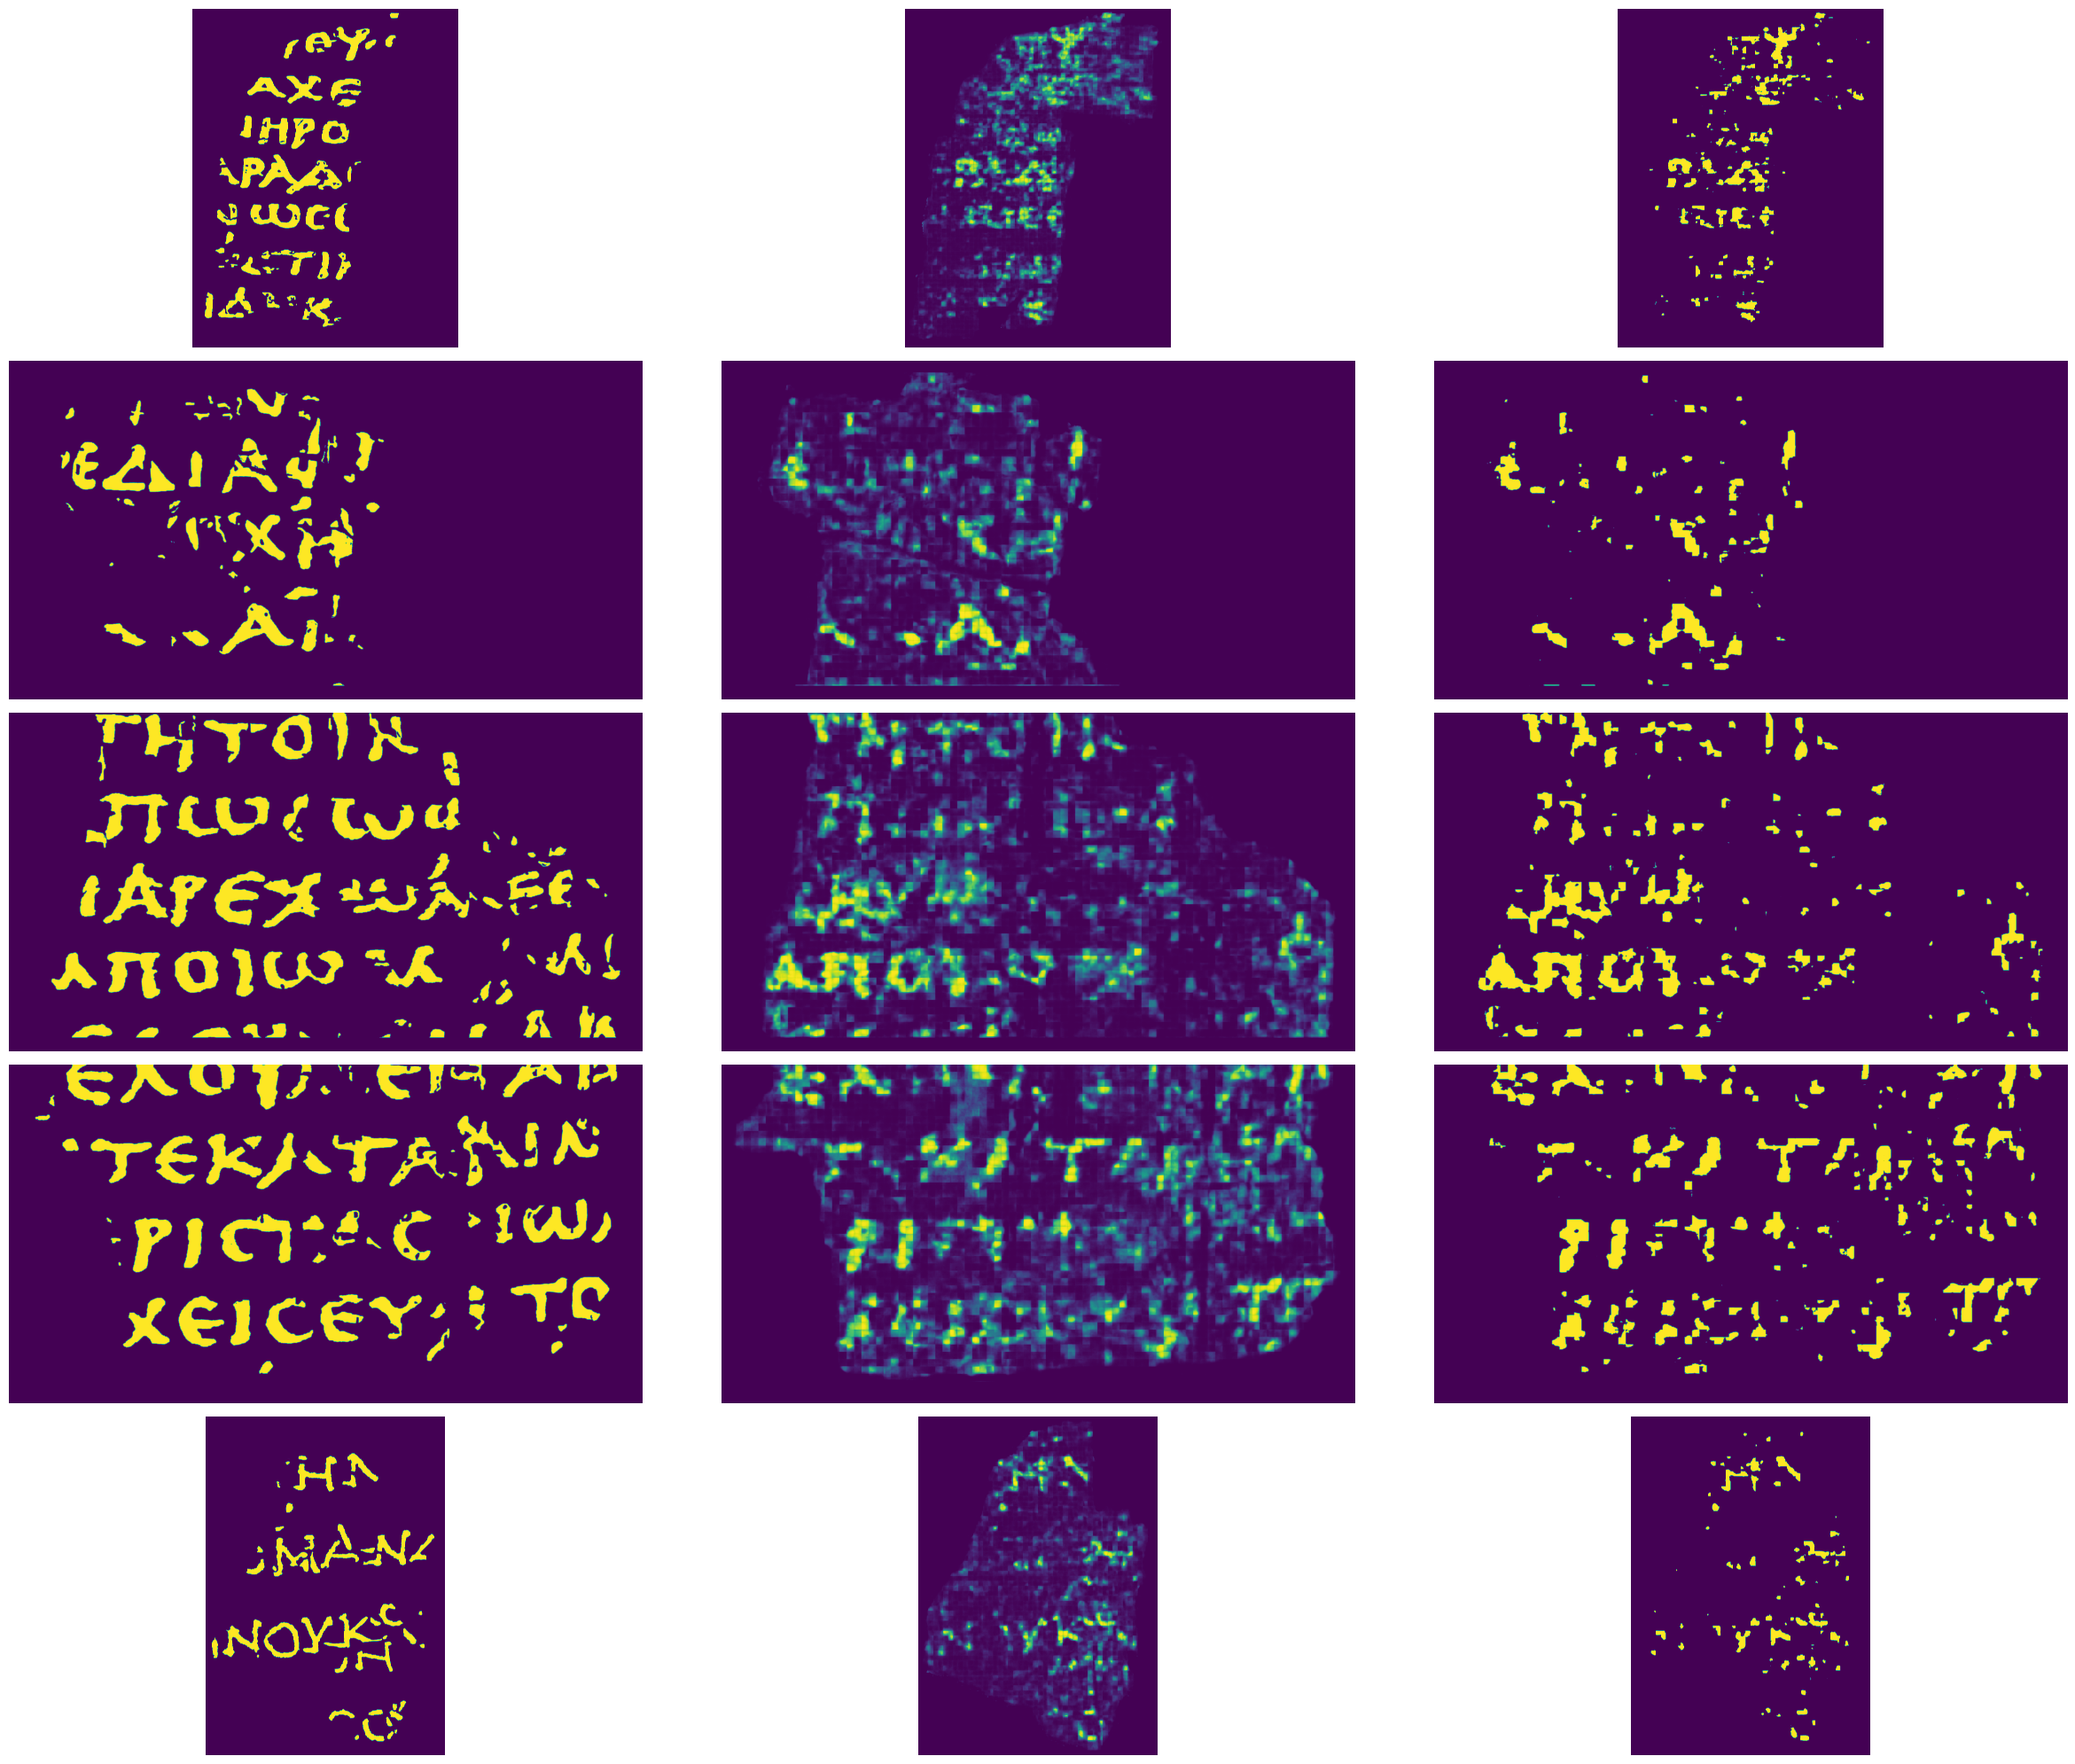

In [11]:
plot_inference(valid_label_gt_list, label_pred_list, CFG)

In [ ]:
!pip install cupy-cuda12x

In [9]:

import cupy as cp
xp = cp

delta_lookup = {
    "xx": xp.array([[1, -2, 1]], dtype=float),
    "yy": xp.array([[1], [-2], [1]], dtype=float),
    "xy": xp.array([[1, -1], [-1, 1]], dtype=float),
}

def operate_derivative(img_shape, pair):
    assert len(img_shape) == 2
    delta = delta_lookup[pair]
    fft = xp.fft.fftn(delta, img_shape)
    return fft * xp.conj(fft)

def soft_threshold(vector, threshold):
    return xp.sign(vector) * xp.maximum(xp.abs(vector) - threshold, 0)

def back_diff(input_image, dim):
    assert dim in (0, 1)
    r, n = xp.shape(input_image)
    size = xp.array((r, n))
    position = xp.zeros(2, dtype=int)
    temp1 = xp.zeros((r+1, n+1), dtype=float)
    temp2 = xp.zeros((r+1, n+1), dtype=float)
    
    temp1[position[0]:size[0], position[1]:size[1]] = input_image
    temp2[position[0]:size[0], position[1]:size[1]] = input_image
    
    size[dim] += 1
    position[dim] += 1
    temp2[position[0]:size[0], position[1]:size[1]] = input_image
    temp1 -= temp2
    size[dim] -= 1
    return temp1[0:size[0], 0:size[1]]

def forward_diff(input_image, dim):
    assert dim in (0, 1)
    r, n = xp.shape(input_image)
    size = xp.array((r, n))
    position = xp.zeros(2, dtype=int)
    temp1 = xp.zeros((r+1, n+1), dtype=float)
    temp2 = xp.zeros((r+1, n+1), dtype=float)
        
    size[dim] += 1
    position[dim] += 1

    temp1[position[0]:size[0], position[1]:size[1]] = input_image
    temp2[position[0]:size[0], position[1]:size[1]] = input_image
    
    size[dim] -= 1
    temp2[0:size[0], 0:size[1]] = input_image
    temp1 -= temp2
    size[dim] += 1
    return -temp1[position[0]:size[0], position[1]:size[1]]

def iter_deriv(input_image, b, scale, mu, dim1, dim2):
    g = back_diff(forward_diff(input_image, dim1), dim2)
    d = soft_threshold(g + b, 1 / mu)
    b = b + (g - d)
    L = scale * back_diff(forward_diff(d - b, dim2), dim1)
    return L, b

def iter_xx(*args):
    return iter_deriv(*args, dim1=1, dim2=1)

def iter_yy(*args):
    return iter_deriv(*args, dim1=0, dim2=0)

def iter_xy(*args):
    return iter_deriv(*args, dim1=0, dim2=1)

def iter_sparse(input_image, bsparse, scale, mu):
    d = soft_threshold(input_image + bsparse, 1 / mu)
    bsparse = bsparse + (input_image - d)
    Lsparse = scale * (d - bsparse)
    return Lsparse, bsparse

def denoise_image(input_image, iter_num=100, fidelity=150, sparsity_scale=10, continuity_scale=0.5, mu=1):
    image_size = xp.shape(input_image)
    #print("Initialize denoising")
    norm_array = (
        operate_derivative(image_size, "xx") + 
        operate_derivative(image_size, "yy") + 
        2 * operate_derivative(image_size, "xy")
    )
    norm_array += (fidelity / mu) + sparsity_scale ** 2
    b_arrays = {
        "xx": xp.zeros(image_size, dtype=float),
        "yy": xp.zeros(image_size, dtype=float),
        "xy": xp.zeros(image_size, dtype=float),
        "L1": xp.zeros(image_size, dtype=float),
    }
    g_update = xp.multiply(fidelity / mu, input_image)
    for i in tqdm(range(iter_num), total=iter_num):
        #print(f"Starting iteration {i+1}")
        g_update = xp.fft.fftn(g_update)
        if i == 0:
            g = xp.fft.ifftn(g_update / (fidelity / mu)).real
        else:
            g = xp.fft.ifftn(xp.divide(g_update, norm_array)).real
        g_update = xp.multiply((fidelity / mu), input_image)
        
        #print("XX update")
        L, b_arrays["xx"] = iter_xx(g, b_arrays["xx"], continuity_scale, mu)
        g_update += L
        
        #print("YY update")
        L, b_arrays["yy"] = iter_yy(g, b_arrays["yy"], continuity_scale, mu)
        g_update += L
        
        #print("XY update")
        L, b_arrays["xy"] = iter_xy(g, b_arrays["xy"], 2 * continuity_scale, mu)
        g_update += L
        
        #print("L1 update")
        L, b_arrays["L1"] = iter_sparse(g, b_arrays["L1"], sparsity_scale, mu)
        g_update += L
        
    g_update = xp.fft.fftn(g_update)
    g = xp.fft.ifftn(xp.divide(g_update, norm_array)).real
    
    g[g < 0] = 0
    g -= g.min()
    g /= g.max()
    return g

100%|██████████| 250/250 [00:42<00:00,  5.85it/s]


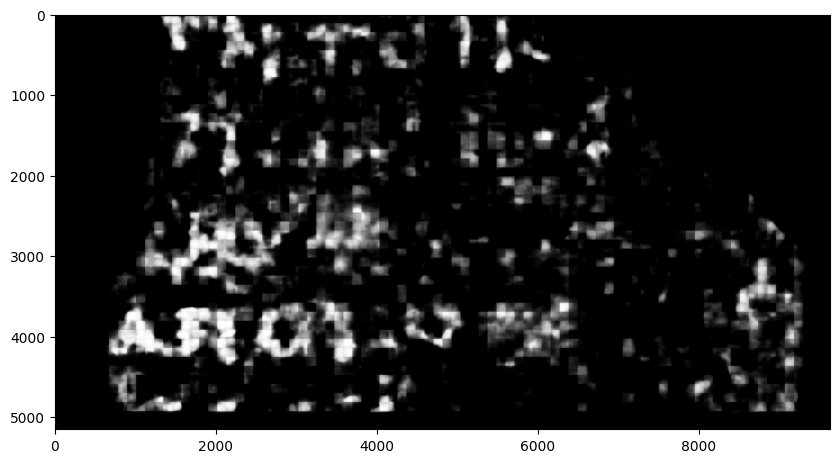

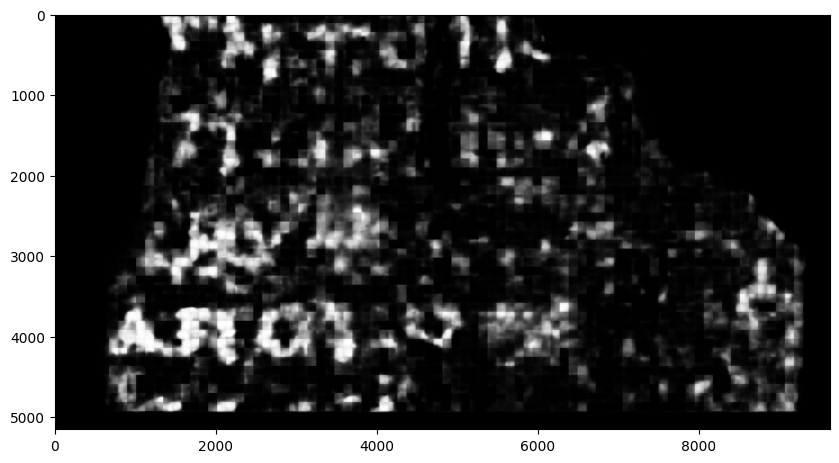

In [21]:
i=2
denoised=denoise_image(cp.array(label_pred_list[i]), iter_num=250).get()

plt.figure(figsize=(10,10))
plt.imshow(denoised)
plt.figure(figsize=(10,10))
plt.imshow(label_pred_list[i])

In [22]:
print(calc_fbeta(valid_label_gt_list[i], denoised))


fbeta: 0.6027
(0.6027326119440631, 0.5)


In [23]:
print(calc_fbeta(valid_label_gt_list[i], label_pred_list[i]))

fbeta: 0.6048
(0.6048107692546469, 0.5)
